## 問題設定

状態ベクトルの次元$n=2$, 入力制御ベクトルの次元$m=1$とし, 線形システム

$$ \dot{x}(t) = f(x(t),u(t))$$

を考える. ここで
$$
f(x,t) = \begin{bmatrix} x_2\\ -x_1^3+x_1 -x_2 + u\end{bmatrix}
$$
とし, 初期値は
$$
x(0)=\begin{bmatrix} 0.1\\ 0\end{bmatrix}
$$

とする. 評価関数は

$$
J=\dfrac12 x^T(T) S_Tx(T) + \int_0^T\dfrac12\left(x^T(t)Qx(t) + u^T(t)Ru(t)\right)\, dt, \quad T=1.5
$$

において
$$
S_f=Q=\begin{bmatrix} 13& 0\\ 0&1\end{bmatrix},\quad
R=\begin{bmatrix} 1 \end{bmatrix}
$$
とする. すなわち

$$
J=\dfrac12 \left(13x_1(T)^2 + x_2(T)^2 \right) +\dfrac12 \int_0^T\left(13x_1(t)^2 + x_2(t)^2 +u(t)^2\right)\, dt.
$$

を最小化する最適制御を考える.

## 制御入力がない場合
まず, 制御入力がなかった場合($u=0$)のダイナミクスを明らかにする

In [1]:
import diffrax
import jax.numpy as jnp
from tqdm.notebook import tqdm_notebook as tqdm

# 問題設定
S_f = jnp.array([[13, 0], [0, 1]], dtype=float)
Q = jnp.array([[13, 0], [0, 1]], dtype=float)
R = jnp.array([[1]], dtype=float)

x_0 = jnp.array([[0.1], [0]], dtype=float)

# 解く区間
t0, t1 = 0, 15
dt = 0.01

# diffrax の出力数
N = 1000

In [2]:
import jax


@jax.jit
def compute_J(x, u):
    N = x.shape[0]  # サンプル数
    dt = (t1 - t0) / N  # 時間刻み

    x_T = x[-1]  # 最後の時刻の状態, 形状は (n, 1)
    terminal_cost = 0.5 * jnp.matmul(x_T.T, jnp.matmul(S_f, x_T)).squeeze()

    xQx = jnp.einsum("nkj,ki,nij->n", x, Q, x)  # 形状は (N,)
    uRu = jnp.einsum("nkj,ki,nij->n", u, R, u)  # 形状は (N,)
    integral_cost = 0.5 * jnp.sum(xQx + uRu) * dt

    # 総コスト J の計算
    J = terminal_cost + integral_cost
    return jnp.sum(J)

In [3]:
# 汎用設定
ts = jnp.linspace(t0, t1, N)
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=ts)

In [4]:
@jax.jit
def function_f(x, u):
    x1, x2 = x
    u1 = u.squeeze()
    return jnp.array([x2, -(x1**3) + x1 - x2 + u1], dtype=float)


def vector_field_x(t, x, args):
    u_t = args.evaluate(t)
    return function_f(x, u_t)


state_eq = diffrax.ODETerm(vector_field_x)

In [5]:
u = jnp.zeros((N, 1, 1))
u_func = diffrax.LinearInterpolation(ts=ts, ys=u)
sol = diffrax.diffeqsolve(state_eq, solver, t0, t1, dt, x_0, args=u_func, saveat=saveat)
x = sol.ys

In [6]:
import matplotlib.pyplot as plt


def plot_control(x, u):
    X = jnp.array(x).reshape(N, 2)
    U = jnp.array(u).reshape(N, 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    for k in range(2):
        plt.plot(ts, X[:, k], label=f"x_{k}")
    plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
    plt.legend()

    plt.subplot(1, 2, 2)
    for k in range(1):
        plt.plot(ts, U[:, k], linestyle="--", label="u")
    plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
    plt.legend()
    plt.show()

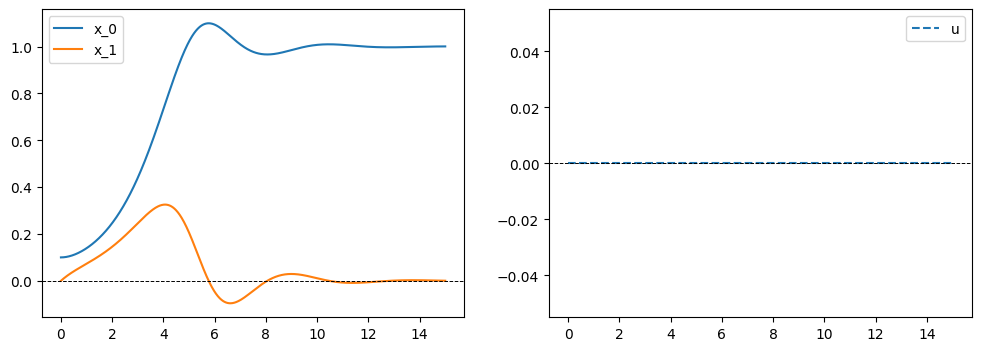

81.38629


In [7]:
plot_control(x, u)
print(compute_J(x, u))

オイラー・ラグランジュ方程式

$$\begin{aligned}
&\dot{x}(t) = Ax(t) + Bu(t),
\quad x(0)=x_0, \\
&\dot{\lambda}(t) =-Qx(t)-A^T \lambda(t) , 
\quad \lambda(t_f) =  S_f (x(t_f)), \\
&u^T(t)R + \lambda^T(t)B=0.
\end{aligned}$$

に対して, ハミルトニアンを$H=L+\lambda^T f$とする.

## 最急降下法

以下のアルゴリズムを構築する

1. 適当な$u$を制御入力の初期推定解とする
2. $u$を用いて状態方程式を解いて$x$を, 随伴方程式を解いて$\lambda$を求める
3. $x$,$u$,$\lambda$から$\frac{\partial H}{\partial u}$を計算する. 
    * 勾配のノルム$\left(\int_{t_0}^{t_f}\left\|\frac{\partial H}{\partial u}\right\|^2\right)^{\frac{1}{2}}$が十分小さければ停止する
4. $s=-\left(\frac{\partial H}{\partial u}\right)^T$とおく
5. 制御入力を $u+\alpha s$としたときの評価関数値$J[u+\alpha s]$が最小になるスカラー$\alpha$を求め, $u=u+\alpha s$と更新してステップ2に戻る

In [8]:
import jax


@jax.jit
def hamiltonian(x, u, lambda_):
    L = 0.5 * (jnp.matmul(x.T, jnp.matmul(Q, x)) + jnp.matmul(u.T, jnp.matmul(R, u)))
    f = function_f(x, u)
    H = L + jnp.matmul(lambda_.T, f)
    return H.squeeze()


grad_H_x = jax.grad(hamiltonian, argnums=0)


def vector_field_lambda(t, lambda_, args):
    x_t = args[0].evaluate(t)
    u = args[1].evaluate(t)
    dot_lambda = grad_H_x(x_t, u, lambda_)
    return dot_lambda


lambda_eq = diffrax.ODETerm(vector_field_lambda)


@jax.jit
def compute_sequential_hamiltonian_and_gradients(x, u, lambda_):
    """
    各時刻におけるハミルトニアンとその u に関する勾配を計算します。

    Parameters:
    x (jnp.array): 状態変数、形状は (N, n, 1)
    u (jnp.array): 制御入力、形状は (N, m, 1)
    lambda_ (jnp.array): ラグランジュ乗数、形状は (N, n, 1)

    Returns:
    Tuple[jnp.array, jnp.array]: ハミルトニアンの配列と勾配の配列
    """
    # ベクトル化されたハミルトニアン関数
    H = jax.vmap(hamiltonian, in_axes=(0, 0, 0))(x, u, lambda_)
    # ベクトル化された勾配関数
    hamiltonian_grad_u = jax.grad(hamiltonian, argnums=1)
    grad_u = jax.vmap(hamiltonian_grad_u, in_axes=(0, 0, 0))(x, u, lambda_)
    return H, grad_u

In [9]:
print(jnp.array([[0], [0]]).shape, jnp.array([0]).shape, jnp.array([[0], [0]]).shape)
hamiltonian(jnp.array([[0], [0]]), jnp.array([0]), jnp.array([[0], [0]]))

(2, 1) (1,) (2, 1)


Array(0., dtype=float32)

In [10]:
u = jnp.zeros((N, 1, 1))
u_func = diffrax.LinearInterpolation(ts=ts, ys=u)
u_0 = u_func.evaluate(0)
lambda_0 = S_f @ x[-1]
print(x_0.shape, u_0.shape, lambda_0.shape)
print(hamiltonian(x_0, u_0, lambda_0))
print(grad_H_x(x_0, u_0, lambda_0))

(2, 1) (1, 1) (2, 1)
0.06504121
[[ 1.3004038]
 [13.011065 ]]


In [11]:
@jax.jit
def J_alpha(alpha, u, s):
    u_new = u + alpha * s
    u_func = diffrax.LinearInterpolation(ts=ts, ys=u_new)
    sol = diffrax.diffeqsolve(state_eq, solver, t0, t1, dt, x_0, args=u_func, saveat=saveat)
    x_new = sol.ys
    return compute_J(x_new, u_new)

In [12]:
from scipy.optimize import minimize_scalar


def minimize_scalar_(x, u, s):
    best_score = compute_J(x, u)
    best_alpha = 0

    for alpha in 0, 1e-16, 1e-12, 1e-10, 1e-8, 1e-6, 1e-5, 1e-3, 0.1:
        u_new = u + alpha * s
        u_func = diffrax.LinearInterpolation(ts=ts, ys=u_new)
        sol = diffrax.diffeqsolve(state_eq, solver, t0, t1, dt, x_0, args=u_func, saveat=saveat)
        x_new = sol.ys
        score = compute_J(x_new, u_new)
        if score < best_score:
            best_alpha = alpha
            best_score = score
    return best_alpha


u = jnp.zeros((N, 1, 1))

for _ in tqdm(range(10**2)):
    u_func = diffrax.LinearInterpolation(ts=ts, ys=u)
    sol = diffrax.diffeqsolve(state_eq, solver, t0, t1, dt, x_0, args=u_func, saveat=saveat)
    x = sol.ys

    lambda_tf = S_f @ x[-1]
    x_func = diffrax.LinearInterpolation(ts=ts, ys=x[::-1])
    sol = diffrax.diffeqsolve(lambda_eq, solver, t0, t1, dt, lambda_tf, args=[x_func, u_func], saveat=saveat)
    lambda_ = sol.ys[::-1]

    H, grad_u = compute_sequential_hamiltonian_and_gradients(x, u, lambda_)

    # u の更新
    grad_norm = jnp.sqrt(jnp.sum(grad_u**2) * dt)
    score = compute_J(x, u)
    s = -grad_u
    alpha_opt = minimize_scalar_(x, u, s)
    alpha_opt = minimize_scalar(J_alpha, bounds=(0, 1), args=(u, s)).x

    u += alpha_opt * s

  0%|          | 0/100 [00:00<?, ?it/s]

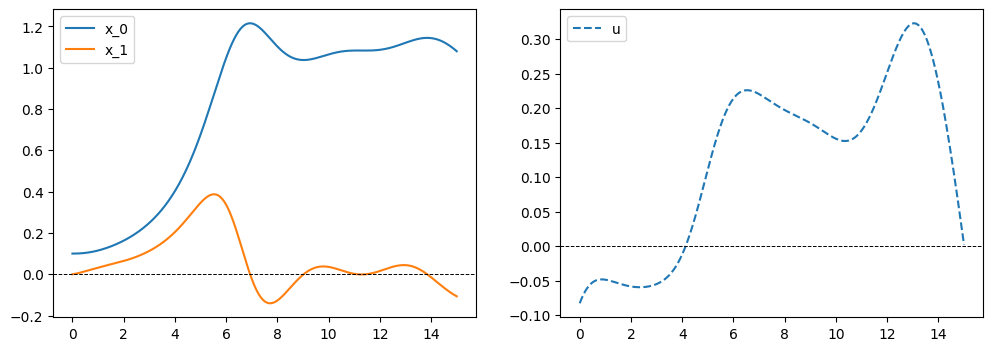

In [13]:
plot_control(x, u)

## 共役勾配法


以下のアルゴリズムを構築する

1. 適当な$u$を制御入力の初期推定解, $s_-=0$, $d_-$は適当（計算に使われない）に置く
2. 制御入力を $u$ としたときの状態方程式の解$x$, 随伴方程式の解$\lambda$ に対して$d = -\frac{\partial H}{\partial u}$ とする
    * 勾配のノルム$\left(\int_{t_0}^{t_f}\left\|d(t)\right\|^2\,dt\right)^{\frac{1}{2}}$が十分小さければ停止する
3. ポラックリビエポリャック法やフレッチャーリーブス法により$\beta$を$d_-, d$ から定める
4. $s=d + \beta s_-$とする
5. 制御入力を $u+\alpha s$としたときの評価関数値$J[u+\alpha s]$が最小になるスカラー$\alpha$を求め, $u=u+\alpha s$とおく
6. $d_-=d, s_-=s$と代入する

In [16]:
# from scipy.optimize import minimize_scalar

u = jnp.zeros((N, 1, 1))
s_ = jnp.zeros((N, 1, 1))
d_ = jnp.ones((N, 1, 1))

for _ in tqdm(range(10**3)):
    u_func = diffrax.LinearInterpolation(ts=ts, ys=u)
    sol = diffrax.diffeqsolve(state_eq, solver, t0, t1, dt, x_0, args=u_func, saveat=saveat)
    x = sol.ys

    lambda_tf = S_f @ x[-1]
    x_func = diffrax.LinearInterpolation(ts=ts, ys=x[::-1])
    sol = diffrax.diffeqsolve(lambda_eq, solver, t0, t1, dt, lambda_tf, args=[x_func, u_func], saveat=saveat)
    lambda_ = sol.ys[::-1]

    H, grad_u = compute_sequential_hamiltonian_and_gradients(x, u, lambda_)
    d = -grad_u

    grad_norm = jnp.sqrt(jnp.sum(d**2) * dt).squeeze()

    beta = jnp.einsum("ijk, ijk", d, d) / jnp.einsum("ijk, ijk", d_, d_)  # フレッチャーリーブス法に
    s = d + beta * s_
    alpha_opt = minimize_scalar_(x, u, s)
    alpha_opt = minimize_scalar(J_alpha, bounds=(0, 1), args=(u, s)).x
    score = compute_J(x, u)

    u += alpha_opt * s

  0%|          | 0/1000 [00:00<?, ?it/s]

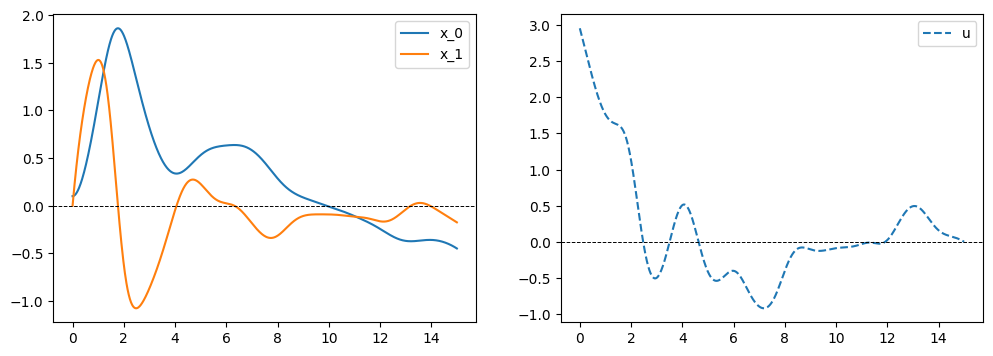

In [17]:
plot_control(x, u)